## Importing Necessary Modules

In [1]:
#Import the required modules
import pandas as pd
import numpy as np
import warnings, pickle, os, pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

warnings.filterwarnings('ignore')

## Importing Data and Visualization

In [2]:
#Read the dataset
physio = pd.read_csv('dataset.csv')
physio.head()

Age Affected body part         Diagnosis Duration of pain  \
0  24.0               knee  patella fracture          chronic   
1  35.0               knee  patella fracture          chronic   
2  26.0               knee  patella fracture          chronic   
3  21.0               knee  patella fracture         subacute   
4  48.0               knee  patella fracture         subacute   

  Intensity of pain     Treatment approach Duration of treatment  
0         9 on nprs  manual and mechanical               22 days  
1         6 on nprs                 manual               40 days  
2         8 on nprs             mechanical               31 days  
3         7 on nprs  manual and mechanical               15 days  
4         8 on nprs  manual and mechanical               17 days

In [3]:
#Converting intensity of pain and treatment duration to integer values from string
physio['Intensity of pain'] = physio['Intensity of pain'].apply(lambda x:int(x.split()[0]))
physio['Duration of treatment'] = physio['Duration of treatment'].apply(lambda x:int(x.split()[0]))
physio.head()

Age Affected body part         Diagnosis Duration of pain  \
0  24.0               knee  patella fracture          chronic   
1  35.0               knee  patella fracture          chronic   
2  26.0               knee  patella fracture          chronic   
3  21.0               knee  patella fracture         subacute   
4  48.0               knee  patella fracture         subacute   

   Intensity of pain     Treatment approach  Duration of treatment  
0                  9  manual and mechanical                     22  
1                  6                 manual                     40  
2                  8             mechanical                     31  
3                  7  manual and mechanical                     15  
4                  8  manual and mechanical                     17

In [4]:
physio.isnull().sum()

Age                      46
Affected body part        0
Diagnosis                 0
Duration of pain          0
Intensity of pain         0
Treatment approach        0
Duration of treatment     0
dtype: int64

In [5]:
#Since age has many null values, drop age

#Since we dont have a diagnosis that relates to multiple body parts,
#We can drop the 'Affected body part' column

physio.drop(['Age', 'Affected body part'], axis=1, inplace=True)

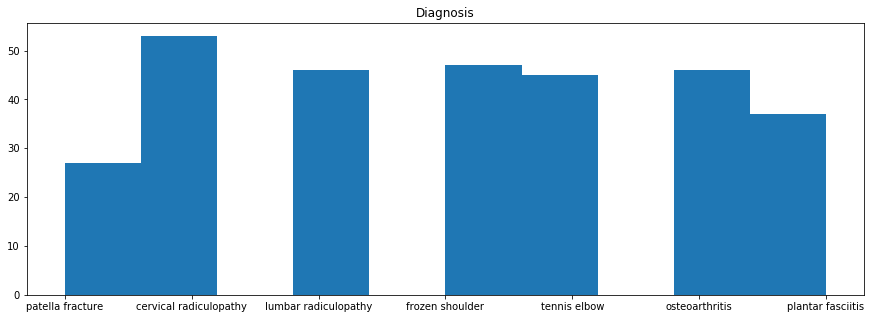

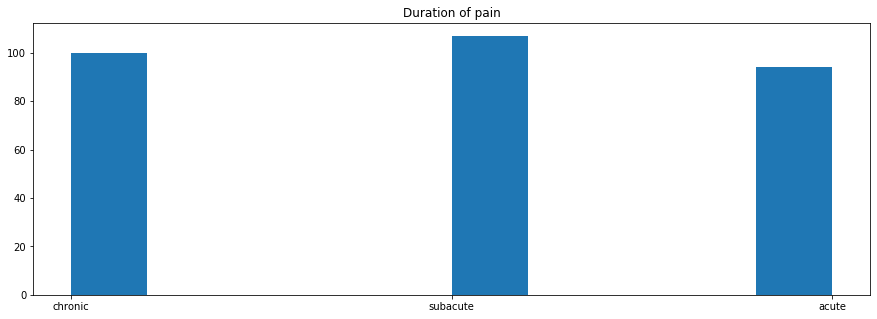

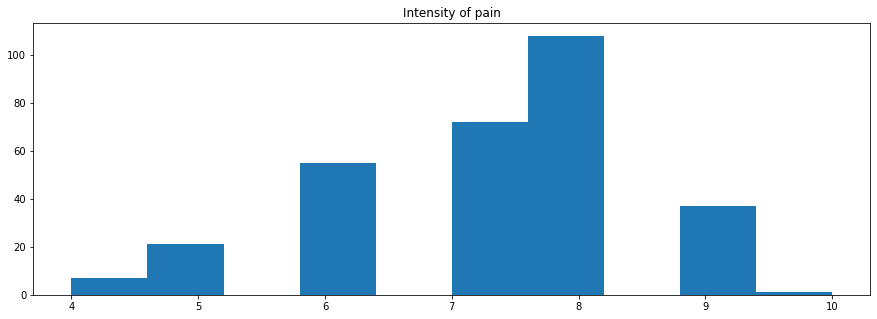

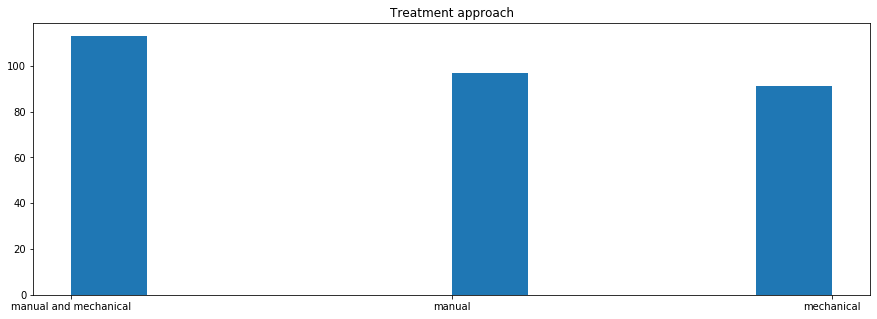

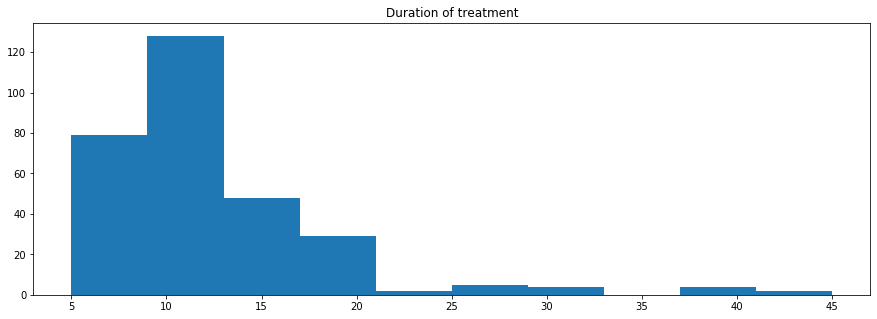

In [6]:
for i in physio.columns:
    fig = plt.figure()
    fig.set_figwidth(15)
    fig.set_figheight(5)
    plt.title(i)
    plt.hist(physio[i], bins=10)
    plt.savefig(os.path.join(os.getcwd(),'plots', f'{i}.png'))
    plt.show()

## Linear Regression 

In [7]:
#Splitting diagnosis into separate columns
diagnosis = pd.get_dummies(physio['Diagnosis'], drop_first=True)
physioLR = pd.concat([physio, diagnosis], axis = 1)
physioLR.drop(['Diagnosis'], axis = 1, inplace = True)
physioLR.head()

Duration of pain  Intensity of pain     Treatment approach  \
0          chronic                  9  manual and mechanical   
1          chronic                  6                 manual   
2          chronic                  8             mechanical   
3         subacute                  7  manual and mechanical   
4         subacute                  8  manual and mechanical   

   Duration of treatment  frozen shoulder  lumbar radiculopathy  \
0                     22                0                     0   
1                     40                0                     0   
2                     31                0                     0   
3                     15                0                     0   
4                     17                0                     0   

   osteoarthritis  patella fracture  plantar fasciitis  tennis elbow  
0               0                 1                  0             0  
1               0                 1                  0             0  
2               0                 1                  0             0  
3               0                 1                  0             0  
4               0                 1                  0             0

In [8]:
#Assigning integer values to treatment approach and pain duration
physioLR['Treatment approach'].replace(['manual','mechanical','manual and mechanical'], [0,1,2], inplace=True)
physioLR['Duration of pain'].replace(['acute','subacute','chronic'], [0,1,2], inplace=True)
physioLR.head()

Duration of pain  Intensity of pain  Treatment approach  \
0                 2                  9                   2   
1                 2                  6                   0   
2                 2                  8                   1   
3                 1                  7                   2   
4                 1                  8                   2   

   Duration of treatment  frozen shoulder  lumbar radiculopathy  \
0                     22                0                     0   
1                     40                0                     0   
2                     31                0                     0   
3                     15                0                     0   
4                     17                0                     0   

   osteoarthritis  patella fracture  plantar fasciitis  tennis elbow  
0               0                 1                  0             0  
1               0                 1                  0             0  
2               0                 1                  0             0  
3               0                 1                  0             0  
4               0                 1                  0             0

In [9]:
#Check for outliers
outliers = []
def detect_outliers_zscore(data):
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code

for col in physioLR.columns[:4]:
    print(f'Outliers in {col} column : {detect_outliers_zscore(physioLR[col])}')

Outliers in Duration of pain column : []
Outliers in Intensity of pain column : []
Outliers in Treatment approach column : []
Outliers in Duration of treatment column : [40, 31, 38, 42, 38, 40, 45]


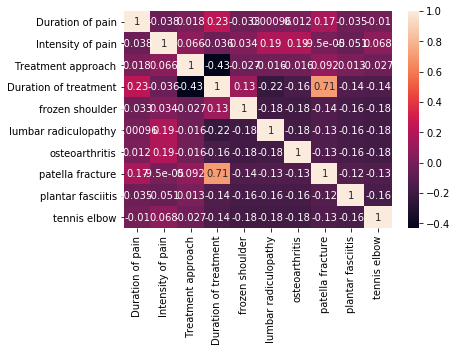

In [10]:
#The outliers do not need to be removed
#Now check the correlation matrix
sns.heatmap(physioLR.corr(), annot=True)

In [11]:
#Patella fracture and Duration if treatment are highly Correlated
#But since its a separate diagnosis, we can not drop it

#Now assign x and y values and split data for training and testing
x = physioLR.drop(['Duration of treatment'], axis=1)
y = physioLR['Duration of treatment']
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=101)

In [12]:
#Define an object of type Linear Regression and train it on our training data
linearRegressor = LinearRegression()
linearRegressor.fit(xtrain,ytrain)

#Predict the values for training and testing data
pred_Train = linearRegressor.predict(xtrain)
pred_Test = linearRegressor.predict(xtest)

#Round off the predicted values
pred_Train = [round(i) for i in pred_Train]
pred_Test = [round(i) for i in pred_Test]

#Score Evaluation
lrTrain = linearRegressor.score(xtrain, ytrain)
lrTest = linearRegressor.score(xtest, ytest)

#Calculate errors in predictions
print('Training Error:')
print('MAE =', mean_absolute_error(pred_Train, ytrain))
print('MSE =', mean_squared_error(pred_Train, ytrain))
print('RMSE =', mean_squared_error(pred_Train, ytrain) ** 0.5)
print('Testing Error:')
print('MAE =', mean_absolute_error(pred_Test, ytest))
print('MSE =', mean_squared_error(pred_Test, ytest))
print('RMSE =', mean_squared_error(pred_Test, ytest) ** 0.5)
print('\nTraining Score :', lrTrain)
print('Testing Score :', lrTest)

Training Error:
MAE = 1.6708333333333334
MSE = 6.595833333333333
RMSE = 2.5682354513037415
Testing Error:
MAE = 1.5737704918032787
MSE = 4.032786885245901
RMSE = 2.008179993239127

Training Score : 0.8357240983738086
Testing Score : 0.8611903473654251


In [ ]:
#The input data needs to be in the following format for prediction using Linear Regression
'''
Duration of pain:
    acute: 0
    subacute: 1
    chronic: 2

Intensity of pain:
    On a scale of 0-10

Treatment Approach:
    manual: 0
    mechanical: 1
    manual and mechanical: 2
    
So the final format of input for different diagnosis is:
    Cervical Radiculopathy: [Duration, Intensity, Approach, 0, 0, 0, 0, 0, 0]
    Frozen Shoulder:        [Duration, Intensity, Approach, 1, 0, 0, 0, 0, 0]
    Tennis Elbow:           [Duration, Intensity, Approach, 0, 1, 0, 0, 0, 0]
    Lumbar Radiculopathy:   [Duration, Intensity, Approach, 0, 0, 1, 0, 0, 0]
    Osteoarthritis:         [Duration, Intensity, Approach, 0, 0, 0, 1, 0, 0]
    Patella Fracture:       [Duration, Intensity, Approach, 0, 0, 0, 0, 1, 0]
    Plantar Fasciitis:      [Duration, Intensity, Appraoch, 0, 0, 0, 0, 0, 1]
'''

## Decision Tree Regressor

In [13]:
#Assigning Numeric value to different strings in diagnosis
physioDT = physio.copy()
diagnosis = list(physioDT['Diagnosis'].unique())
physioDT['Diagnosis'].replace(diagnosis, range(len(diagnosis)), inplace=True)
physioDT.head()

Diagnosis Duration of pain  Intensity of pain     Treatment approach  \
0          0          chronic                  9  manual and mechanical   
1          0          chronic                  6                 manual   
2          0          chronic                  8             mechanical   
3          0         subacute                  7  manual and mechanical   
4          0         subacute                  8  manual and mechanical   

   Duration of treatment  
0                     22  
1                     40  
2                     31  
3                     15  
4                     17

In [14]:
#Assigning integer values to treatment approach and pain duration
physioDT['Treatment approach'].replace(['manual','mechanical','manual and mechanical'], [0,1,2], inplace=True)
physioDT['Duration of pain'].replace(['acute','subacute','chronic'], [0,1,2], inplace=True)
physioDT.head()

Diagnosis  Duration of pain  Intensity of pain  Treatment approach  \
0          0                 2                  9                   2   
1          0                 2                  6                   0   
2          0                 2                  8                   1   
3          0                 1                  7                   2   
4          0                 1                  8                   2   

   Duration of treatment  
0                     22  
1                     40  
2                     31  
3                     15  
4                     17

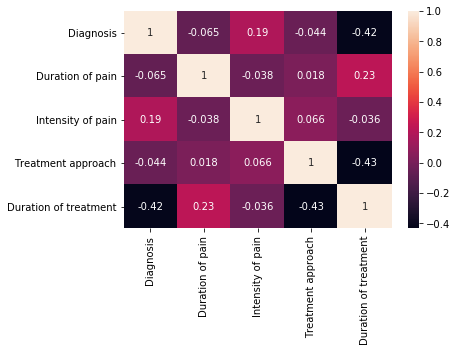

In [15]:
#Now check the correlation matrix
sns.heatmap(physioDT.corr(), annot=True)

In [16]:
#Now assign x and y values and split data for training and testing
x = physioDT.drop(['Duration of treatment'], axis=1)
y = physioDT['Duration of treatment']
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=101)

Training Error:
MAE = 0.12916666666666668
MSE = 0.22916666666666666
RMSE = 0.47871355387816905
Testing Error:
MAE = 0.5245901639344263
MSE = 1.6065573770491803
RMSE = 1.2675004445952593

Training Score : 0.9947860700731009
Testing Score : 0.942134007370769

Tree Depth : 10


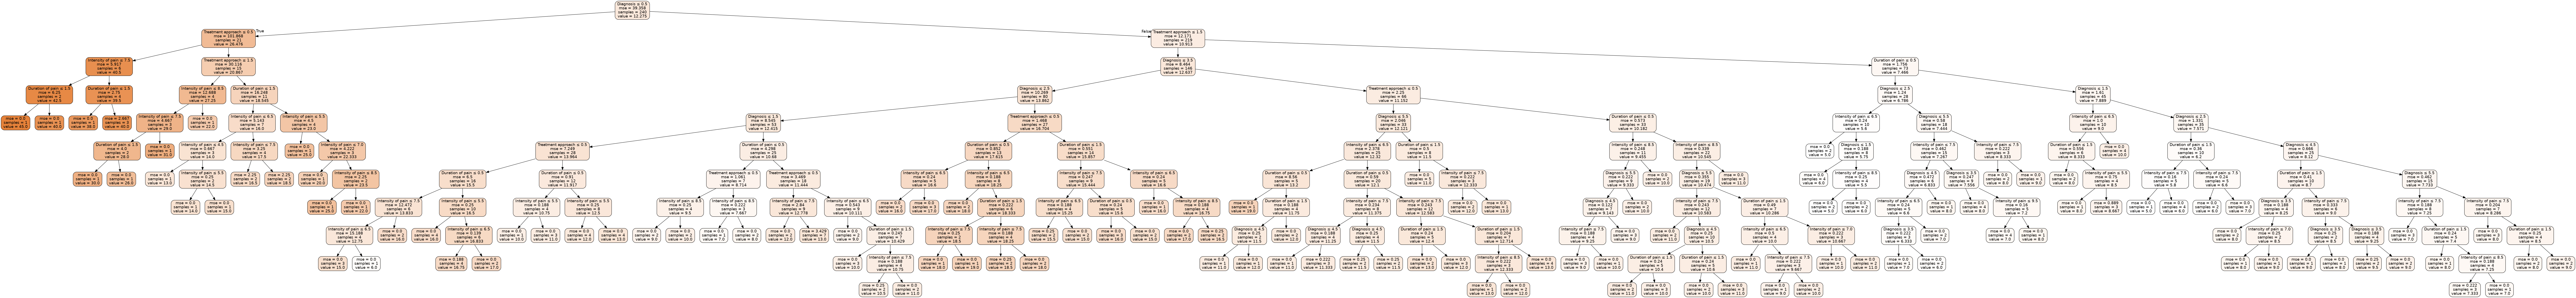

In [17]:
#Define an object of type Decision Tree and train it on our training data
decisionTree_max = DecisionTreeRegressor()
decisionTree_max.fit(xtrain,ytrain)

#Predict the values for training and testing data
pred_Train = decisionTree_max.predict(xtrain)
pred_Test = decisionTree_max.predict(xtest)

#Round off the predicted values
pred_Train = [round(i) for i in pred_Train]
pred_Test = [round(i) for i in pred_Test]

#Score Evaluation
dtTrain_max = decisionTree_max.score(xtrain, ytrain)
dtTest_max = decisionTree_max.score(xtest, ytest)

#Calculate errors in predictions
print('Training Error:')
print('MAE =', mean_absolute_error(pred_Train, ytrain))
print('MSE =', mean_squared_error(pred_Train, ytrain))
print('RMSE =', mean_squared_error(pred_Train, ytrain) ** 0.5)
print('Testing Error:')
print('MAE =', mean_absolute_error(pred_Test, ytest))
print('MSE =', mean_squared_error(pred_Test, ytest))
print('RMSE =', mean_squared_error(pred_Test, ytest) ** 0.5)
print('\nTraining Score :', dtTrain_max)
print('Testing Score :', dtTest_max)
print('\nTree Depth :', decisionTree_max.get_depth())

dot_data = StringIO()
export_graphviz(decisionTree_max, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = list(x.columns),class_names=['0','1'])
graph_DT10 = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Training Error:
MAE = 0.15416666666666667
MSE = 0.25416666666666665
RMSE = 0.5041494487418058
Testing Error:
MAE = 0.5737704918032787
MSE = 1.6557377049180328
RMSE = 1.2867547182419938

Training Score : 0.9943555459099322
Testing Score : 0.941230007866464

Tree Depth : 9


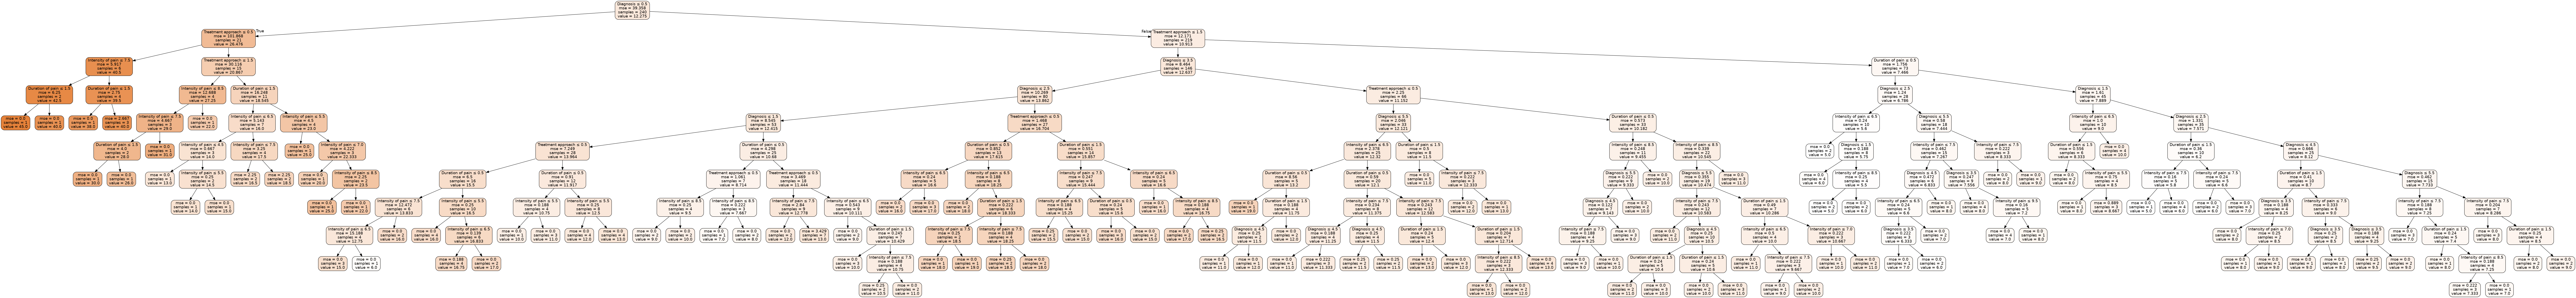

In [18]:
#Define an object of type Decision Tree and train it on our training data
decisionTree_9 = DecisionTreeRegressor(max_depth=9)
decisionTree_9.fit(xtrain,ytrain)

#Predict the values for training and testing data
pred_Train = decisionTree_9.predict(xtrain)
pred_Test = decisionTree_9.predict(xtest)

#Round off the predicted values
pred_Train = [round(i) for i in pred_Train]
pred_Test = [round(i) for i in pred_Test]

#Score Evaluation
dtTrain_9 = decisionTree_9.score(xtrain, ytrain)
dtTest_9 = decisionTree_9.score(xtest, ytest)

#Calculate errors in predictions
print('Training Error:')
print('MAE =', mean_absolute_error(pred_Train, ytrain))
print('MSE =', mean_squared_error(pred_Train, ytrain))
print('RMSE =', mean_squared_error(pred_Train, ytrain) ** 0.5)
print('Testing Error:')
print('MAE =', mean_absolute_error(pred_Test, ytest))
print('MSE =', mean_squared_error(pred_Test, ytest))
print('RMSE =', mean_squared_error(pred_Test, ytest) ** 0.5)
print('\nTraining Score :', dtTrain_9)
print('Testing Score :', dtTest_9)
print('\nTree Depth :', decisionTree_9.get_depth())

dot_data = StringIO()
export_graphviz(decisionTree_9, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = list(x.columns),class_names=['0','1'])
graph_DT9 = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
#The input data needs to be in the following format for prediction using Decision Tree
'''
Diagnosis:
    Patella Fracture:       0
    Cervical Radiculopathy: 1
    Lumbar Radiculopathy:   2
    Frozen Shoulder:        3
    Tennis Elbow:           4
    Osteoarthritis:         5
    Plantar Fasciitis:      6
    
Duration of pain:
    acute: 0
    subacute: 1
    chronic: 2

Intensity of pain:
    On a scale of 0-9

Treatment Approach:
    manual: 0
    mechanical: 1
    manual and mechanical: 2
    
Input Format : [Diagnosis, Duration of pain, Intensity of pain, Treatment Approach]
'''

## Random Forest Regressor

In [19]:
#Assigning Numeric value to different strings in diagnosis
physioRF = physio.copy()
diagnosis = list(physioRF['Diagnosis'].unique())
physioRF['Diagnosis'].replace(diagnosis, range(len(diagnosis)), inplace=True)
physioRF.head()

Diagnosis Duration of pain  Intensity of pain     Treatment approach  \
0          0          chronic                  9  manual and mechanical   
1          0          chronic                  6                 manual   
2          0          chronic                  8             mechanical   
3          0         subacute                  7  manual and mechanical   
4          0         subacute                  8  manual and mechanical   

   Duration of treatment  
0                     22  
1                     40  
2                     31  
3                     15  
4                     17

In [20]:
#Assigning integer values to treatment approach and pain duration
physioRF['Treatment approach'].replace(['manual','mechanical','manual and mechanical'], [0,1,2], inplace=True)
physioRF['Duration of pain'].replace(['acute','subacute','chronic'], [0,1,2], inplace=True)
physioRF.head()

Diagnosis  Duration of pain  Intensity of pain  Treatment approach  \
0          0                 2                  9                   2   
1          0                 2                  6                   0   
2          0                 2                  8                   1   
3          0                 1                  7                   2   
4          0                 1                  8                   2   

   Duration of treatment  
0                     22  
1                     40  
2                     31  
3                     15  
4                     17

In [21]:
#Now assign x and y values and split data for training and testing
x = physioRF.drop(['Duration of treatment'], axis=1)
y = physioRF['Duration of treatment']
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=101)

In [22]:
#Define an object of type Decision Tree and train it on our training data
randomForest_max = RandomForestRegressor()
randomForest_max.fit(xtrain,ytrain)

#Predict the values for training and testing data
pred_Train = randomForest_max.predict(xtrain)
pred_Test = randomForest_max.predict(xtest)

#Round off the predicted values
pred_Train = [round(i) for i in pred_Train]
pred_Test = [round(i) for i in pred_Test]

#Score Evaluation
rfTrain_max = randomForest_max.score(xtrain, ytrain)
rfTest_max = randomForest_max.score(xtest, ytest)

#Calculate errors in predictions
print('Training Error:')
print('MAE =', mean_absolute_error(pred_Train, ytrain))
print('MSE =', mean_squared_error(pred_Train, ytrain))
print('RMSE =', mean_squared_error(pred_Train, ytrain) ** 0.5)
print('Testing Error:')
print('MAE =', mean_absolute_error(pred_Test, ytest))
print('MSE =', mean_squared_error(pred_Test, ytest))
print('RMSE =', mean_squared_error(pred_Test, ytest) ** 0.5)
print('\nTraining Score :', rfTrain_max)
print('Testing Score :', rfTest_max)
print('\nTree Depth :', randomForest_max.n_estimators)

Training Error:
MAE = 0.2791666666666667
MSE = 0.5041666666666667
RMSE = 0.710046946804693
Testing Error:
MAE = 0.7213114754098361
MSE = 2.459016393442623
RMSE = 1.56812512046795

Training Score : 0.9870159227640766
Testing Score : 0.9141411337799441

Tree Depth : 100


In [23]:
#Define an object of type Decision Tree and train it on our training data
randomForest_50 = RandomForestRegressor(n_estimators=50)
randomForest_50.fit(xtrain,ytrain)

#Predict the values for training and testing data
pred_Train = randomForest_50.predict(xtrain)
pred_Test = randomForest_50.predict(xtest)

#Round off the predicted values
pred_Train = [round(i) for i in pred_Train]
pred_Test = [round(i) for i in pred_Test]

#Score Evaluation
rfTrain_50 = randomForest_50.score(xtrain, ytrain)
rfTest_50 = randomForest_50.score(xtest, ytest)

#Calculate errors in predictions
print('Training Error:')
print('MAE =', mean_absolute_error(pred_Train, ytrain))
print('MSE =', mean_squared_error(pred_Train, ytrain))
print('RMSE =', mean_squared_error(pred_Train, ytrain) ** 0.5)
print('Testing Error:')
print('MAE =', mean_absolute_error(pred_Test, ytest))
print('MSE =', mean_squared_error(pred_Test, ytest))
print('RMSE =', mean_squared_error(pred_Test, ytest) ** 0.5)
print('\nTraining Score :', rfTrain_50)
print('Testing Score :', rfTest_50)
print('\nTree Depth :', randomForest_50.n_estimators)

Training Error:
MAE = 0.3
MSE = 0.6333333333333333
RMSE = 0.7958224257542215
Testing Error:
MAE = 0.6721311475409836
MSE = 2.4098360655737703
RMSE = 1.552364669004603

Training Score : 0.9842065800172972
Testing Score : 0.9171481204026739

Tree Depth : 50


In [24]:
#Define an object of type Decision Tree and train it on our training data
randomForest_25 = RandomForestRegressor(n_estimators=25)
randomForest_25.fit(xtrain,ytrain)

#Predict the values for training and testing data
pred_Train = randomForest_25.predict(xtrain)
pred_Test = randomForest_25.predict(xtest)

#Round off the predicted values
pred_Train = [round(i) for i in pred_Train]
pred_Test = [round(i) for i in pred_Test]

#Score Evaluation
rfTrain_25 = randomForest_25.score(xtrain, ytrain)
rfTest_25 = randomForest_25.score(xtest, ytest)

#Calculate errors in predictions
print('Training Error:')
print('MAE =', mean_absolute_error(pred_Train, ytrain))
print('MSE =', mean_squared_error(pred_Train, ytrain))
print('RMSE =', mean_squared_error(pred_Train, ytrain) ** 0.5)
print('Testing Error:')
print('MAE =', mean_absolute_error(pred_Test, ytest))
print('MSE =', mean_squared_error(pred_Test, ytest))
print('RMSE =', mean_squared_error(pred_Test, ytest) ** 0.5)
print('\nTraining Score :', rfTrain_25)
print('Testing Score :', rfTest_25)
print('\nTree Depth :', randomForest_25.n_estimators)

Training Error:
MAE = 0.29583333333333334
MSE = 0.5875
RMSE = 0.7664854858377946
Testing Error:
MAE = 0.7377049180327869
MSE = 2.6065573770491803
RMSE = 1.6144836255128698

Training Score : 0.9859798778467507
Testing Score : 0.9100045698251719

Tree Depth : 25


In [25]:
#Define an object of type Decision Tree and train it on our training data
randomForest_10 = RandomForestRegressor(n_estimators=10)
randomForest_10.fit(xtrain,ytrain)

#Predict the values for training and testing data
pred_Train = randomForest_10.predict(xtrain)
pred_Test = randomForest_10.predict(xtest)

#Round off the predicted values
pred_Train = [round(i) for i in pred_Train]
pred_Test = [round(i) for i in pred_Test]

#Score Evaluation
rfTrain_10 = randomForest_10.score(xtrain, ytrain)
rfTest_10 = randomForest_10.score(xtest, ytest)

#Calculate errors in predictions
print('Training Error:')
print('MAE =', mean_absolute_error(pred_Train, ytrain))
print('MSE =', mean_squared_error(pred_Train, ytrain))
print('RMSE =', mean_squared_error(pred_Train, ytrain) ** 0.5)
print('Testing Error:')
print('MAE =', mean_absolute_error(pred_Test, ytest))
print('MSE =', mean_squared_error(pred_Test, ytest))
print('RMSE =', mean_squared_error(pred_Test, ytest) ** 0.5)
print('\nTraining Score :', rfTrain_10)
print('Testing Score :', rfTest_10)
print('\nTree Depth :', randomForest_10.n_estimators)

Training Error:
MAE = 0.3
MSE = 0.6333333333333333
RMSE = 0.7958224257542215
Testing Error:
MAE = 0.6229508196721312
MSE = 2.19672131147541
RMSE = 1.4821340396453386

Training Score : 0.9842295057587754
Testing Score : 0.9290784256625741

Tree Depth : 10


In [ ]:
#The input data needs to be in the following format for prediction using Random Forest
'''
Diagnosis:
    Patella Fracture:       0
    Cervical Radiculopathy: 1
    Lumbar Radiculopathy:   2
    Frozen Shoulder:        3
    Tennis Elbow:           4
    Osteoarthritis:         5
    Plantar Fasciitis:      6
    
Duration of pain:
    acute: 0
    subacute: 1
    chronic: 2

Intensity of pain:
    On a scale of 0-9

Treatment Approach:
    manual: 0
    mechanical: 1
    manual and mechanical: 2
    
Input Format : [Diagnosis, Duration of pain, Intensity of pain, Treatment Approach]
'''

## Model Comparison

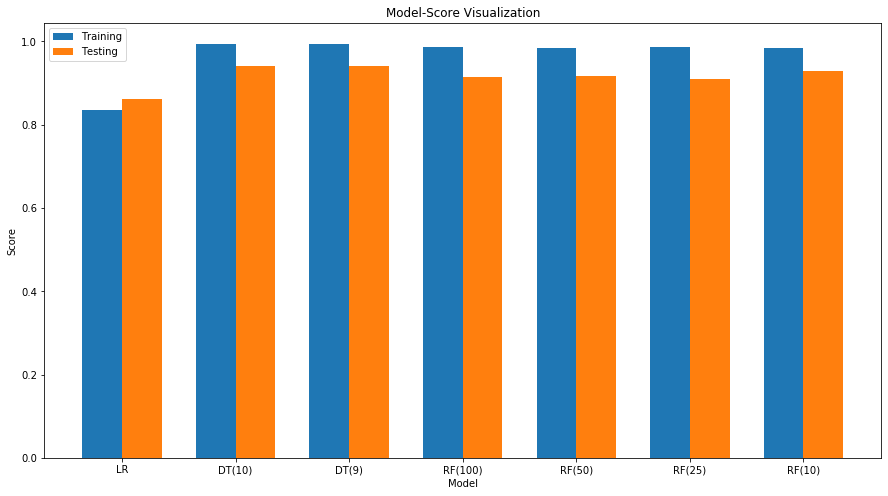

In [26]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)
index = np.arange(7)
bar_width = 0.35

models = ['LR', 'DT(10)', 'DT(9)', 'RF(100)', 'RF(50)', 'RF(25)', 'RF(10)']

trainScores = [lrTrain, dtTrain_max, dtTrain_9, rfTrain_max, rfTrain_50, rfTrain_25, rfTrain_10]
training = ax.bar(index, trainScores, bar_width, label="Training")

testScores = [lrTest, dtTest_max, dtTest_9, rfTest_max, rfTest_50, rfTest_25, rfTest_10]
winter = ax.bar(index+bar_width, testScores, bar_width, label="Testing")

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model-Score Visualization')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()
fig.savefig(os.path.join(os.getcwd(),'plots','resultAnalysis.png'))

In [ ]:
'''
From the above analysis and comparison of scores and errors,
we can conclude that the decision tree with depth of 9 is the
best model for the prediction of duration of physiotherapy
We can now save this model and use it for the web app
'''

In [27]:
graph_DT9.write_png(os.path.join(os.getcwd(),'plots','decisionTree.png'))
pickle.dump(decisionTree_9, open('modelDecisionTree.pkl', 'wb'))